In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.learner import *

import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *

import dill as pickle
import itertools as it
from operator import itemgetter

from spooky import *

In [3]:
PATH = 'data/spooky'

os.makedirs(f'{PATH}/models', exist_ok=True)
os.makedirs(f'{PATH}/tmp', exist_ok=True)

bs = 64
bptt = 75

# for NLP, configure Adam to use less momentum than the defaul of 0.9
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [4]:
# get raw training and test datasets
train_raw_df = pd.read_csv(f'{PATH}/train.csv')
test_df = pd.read_csv(f'{PATH}/test.csv')

len(train_raw_df), len(test_df)

(19579, 8392)

## Get a baseline

Running with default parameters to figure out good default hyperparameters

In [5]:
# Standard CV

# To build a standard cross-validation dataset use this
val_idxs = get_cv_idxs(len(train_raw_df), val_pct=0.20)

train_df =  train_raw_df.drop(val_idxs)
val_df = train_raw_df.iloc[val_idxs]

len(train_df), len(val_df), len(test_df)

(15664, 3915, 8392)

In [6]:
# tokenize = split each sentence into a list of words
' '.join(spacy_tok(train_df.text.iloc[0]))

'It never once occurred to me that the fumbling might be a mere mistake .'

In [7]:
#createa torchtext field = describes how to preprocess a piece of text
txt_fld = data.Field(lower=True, tokenize=spacy_tok)

In [8]:
dataframes = dict(train_df=train_df, val_df=val_df, test_df=val_df)

# min_freq = 10 says, "treat any word that appears less than 10 times as the word <unk>"
md = LanguageModelData.from_dataframes(PATH, txt_fld, 'text', **dataframes, 
                                       bs=bs, bptt=bptt, min_freq=10)

In [9]:
# after building the ModelData object, TEXT.vocab is set.  because this will be needed again, save it
pickle.dump(txt_fld, open(f'{PATH}/models/TEXT_baseline.pkl', 'wb'))

In [10]:
# batches, # of unique tokens in vocab, # of items in ds, # of words in ds
len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

(98, 4146, 1, 476141)

In [11]:
# int to string mapping
txt_fld.vocab.itos[:12]

['<unk>', '<pad>', ',', 'the', 'of', '.', 'and', 'to', 'i', 'a', 'in', 'was']

In [12]:
# string to int mapping
txt_fld.vocab.stoi['the']

3

In [13]:
# in a LanguageModelData object there is only one item in each dataset: all the words joined together
md.trn_ds[0].text[:12]

['it',
 'never',
 'once',
 'occurred',
 'to',
 'me',
 'that',
 'the',
 'fumbling',
 'might',
 'be',
 'a']

In [14]:
# torchtext will handle turning this words into integer Ids
txt_fld.numericalize([md.trn_ds[0].text[:12]])

Variable containing:
   16
   98
  131
  826
    7
   27
   12
    3
    0
   88
   33
    9
[torch.cuda.LongTensor of size 12x1 (GPU 0)]

In [15]:
batch = next(iter(md.trn_dl))
print(batch[0].size()), print(batch[1].size())

batch

torch.Size([81, 64])
torch.Size([5184])


(Variable containing:
    16     2    25  ...     32   101     2
    98    29     3  ...    111     7    15
   131    62  1206  ...    286  3449     9
        ...          ⋱          ...       
   384     3     5  ...     46     2    30
    21   746    15  ...      8   106     3
    17     4   235  ...      0   194    71
 [torch.cuda.LongTensor of size 81x64 (GPU 0)], Variable containing:
    98
    29
     3
   ⋮  
     3
  3894
   268
 [torch.cuda.LongTensor of size 5184 (GPU 0)])

In [16]:
emb_sz = 200       # size of each embedding vector
n_hidden = 500     # number of hidden activations per layer
n_layers = 3       # number of layers

In [17]:
learner = md.get_model(opt_fn, emb_sz, n_hidden, n_layers,
                      dropouti=0.1, dropout=0.1, wdrop=0.2, dropoute=0.04, dropouth=0.1)

learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip = 0.3

In [18]:
lrf = learner.lr_find() 

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 94%|█████████▍| 92/98 [00:14<00:00,  6.41it/s, loss=30.1]

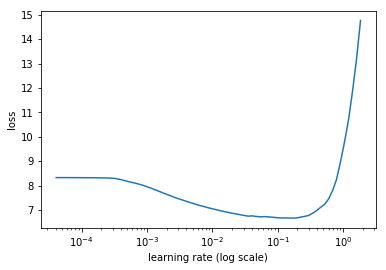

In [19]:
learner.sched.plot()

In [20]:
lr = 3e-3
wds = 1e-6

In [21]:
learner.fit(lr, 4, wds=wds, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))


 11%|█         | 11/98 [00:01<00:12,  6.84it/s, loss=7.75]

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during

[ 0.       5.60124  5.3522 ]                              
[ 1.       5.21798  4.96716]                              
[ 2.       5.0105   4.88868]                              
[ 3.       4.90877  4.75563]                              
[ 4.       4.7773   4.64693]                              
[ 5.       4.67476  4.5883 ]                              
[ 6.       4.61976  4.57182]                              
[ 7.       4.6308   4.53496]                              
[ 8.       4.54769  4.4783 ]                              
[ 9.       4.46852  4.42544]                              
[ 10.        4.39591   4.38997]                           
[ 11.        4.32077   4.36902]                           
[ 12.        4.26214   4.36149]                           
[ 13.        4.22476   4.36028]                           
[ 14.        4.21858   4.35815]                           



In [22]:
learner.save_encoder('spooky_adam_enc1')
# learner.load_encoder('spooky_adam1_enc')

In [23]:
learner.fit(lr, 2, wds=wds, cycle_len=5, cycle_save_name='spooky_adam_enc2_fit')

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

[ 0.       4.28669  4.36529]                              
[ 1.       4.23212  4.34597]                              
[ 2.       4.16397  4.33624]                              
[ 3.       4.09018  4.33146]                              
[ 4.       4.05195  4.33561]                              
[ 5.       4.13678  4.34258]                              
[ 6.       4.09634  4.33769]                              
[ 7.       4.01691  4.334  ]                              
[ 8.       3.93991  4.33712]                              
[ 9.       3.89223  4.34943]                              



In [24]:
learner.save_encoder('spooky_adam_enc2')

In [25]:
learner.fit(lr, 1, wds=wds, cycle_len=10, cycle_save_name='spooky_adam_enc3_fit')

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

[ 0.       3.96945  4.35186]                              
[ 1.       3.98003  4.34813]                              
[ 2.       3.95372  4.33913]                              
[ 3.       3.88543  4.36669]                              
[ 4.       3.83834  4.36485]                              
[ 5.       3.77152  4.3766 ]                              
[ 6.       3.7227   4.39104]                              
[ 7.       3.69084  4.39227]                              
[ 8.       3.6782   4.40122]                              
[ 9.       3.68639  4.41268]                              



In [26]:
learner.save_encoder('spooky_adam_enc3')

In [27]:
# metric perplexity (how language model accuracy generally measured) = exp() of loss function
np.exp(4.38588)

80.308863926683813

## Test

In [28]:
# create a short bit of text to "prime" the precitions, then use torchtext to numericalize it
# so we can feed it into our language model
m = learner.model
ss = """. It was a dark and scary night. The old"""
s = [spacy_tok(ss)]
t = txt_fld.numericalize(s)
' '.join(s[0])

'. It was a dark and scary night . The old'

In [29]:
m[0].bs = 1      # set batch size = 1
m.eval()         # turn-off dropout
m.reset()        # reset hidden state
res, *_ = m(t)   # get predictions from model
m[0].bs = bs     # put batch size back to what it was

In [30]:
# top 10 predictions for next word
nexts = torch.topk(res[-1], 10)[1]
[txt_fld.vocab.itos[o] for o in to_np(nexts)]

['<unk>',
 'men',
 'man',
 'things',
 'l.',
 'zadok',
 'john',
 'whateley',
 ',',
 'ones']

In [31]:
# try to generate more text
print(ss, "\n")

for i in range(50):
    n = res[-1].topk(2)[1]
    n = n[1] if n.data[0] == 0 else n[0]
    print(txt_fld.vocab.itos[n.data[0]], end=' ')
    res, *_ = m(n[0].unsqueeze(0))
    
print('...')

. It was a dark and scary night. The old 

men , the old man , who had been the old man , had been the most remarkable and most remarkable of the family . " the old man was very well , and i was not sure that the old man was dead . " the old man was ...


## GridSearchCV

Do a grid search to figure out params

In [32]:
# GridSearchCV ...

# 1. Define hyper parameters
# size of each embedding vector, # of hidden activations per layer, # of layers, min word freq, ps ratio
params = { 
    'emb_sz': [200, 400, 600], 
    'n_hidden': [512, 1024], 
    'n_layers': [3, 4], 
    'min_freq': [10],
    'ps_mult': [1, 2]
}

# 2. Define folds
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3, shuffle=True)

# get folds
kfolds = [ (train_idxs, val_idxs) for train_idxs, val_idxs in skf.split(train_raw_df.id, train_raw_df.author) ]

# 3. Get all permutations of hyperparameters
param_names = sorted(params)
param_combos = [dict(zip(param_names, prod)) for prod in it.product(*(params[k] for k in param_names))]

In [33]:
lr = 3e-3
wds = 1e-6

for hps in param_combos:
    # get params for this run
    emb_sz, n_hidden, n_layers, min_freq, ps_mult = itemgetter(
        'emb_sz', 'n_hidden', 'n_layers', 'min_freq', 'ps_mult')(hps)

    fold_metrics = []
    
    for f in kfolds:
        # build train/val dataframes
        train_df =  train_raw_df.iloc[f[0]]
        val_df = train_raw_df.iloc[f[1]]
        
        #create torchtext field = describes how to preprocess a piece of text
        txt_fld = data.Field(lower=True, tokenize=spacy_tok)
        
        dataframes = dict(train_df=train_df, val_df=val_df, test_df=test_df)

        # min_freq = 10 says, "treat any word that appears less than 10 times as the word <unk>"
        md = LanguageModelData.from_dataframes(PATH, txt_fld, 'text', **dataframes, 
                                               bs=bs, bptt=bptt, min_freq=min_freq)
        
        learner = md.get_model(opt_fn, emb_sz, n_hidden, n_layers,
                               dropouti=0.1*ps_mult, 
                               dropout=0.1*ps_mult, 
                               wdrop=0.2*ps_mult, 
                               dropoute=0.04*ps_mult, 
                               dropouth=0.1*ps_mult)

        learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
        learner.clip = 0.3
        
        learner.fit(lr, 4, wds=wds, cycle_len=1, cycle_mult=2)     
        learner.fit(lr, 1, wds=wds, cycle_len=5)
        
        val_preds, val_targs = learner.predict_with_targs()
        
        val_acc = accuracy(val_preds, val_targs)
        val_loss = F.cross_entropy(V(T(val_preds)), V(T(val_targs)))
        
        fold_metrics.append({'acc': val_acc, 'loss': val_loss.data})
        
    hps['val_acc'] = sum(m['acc'] for m in fold_metrics) / len(kfolds)
    hps['val_loss'] = sum(m['loss'] for m in fold_metrics) / len(kfolds)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.69303  5.48513]                              
[ 1.       5.36675  5.1286 ]                              
[ 2.       5.16739  5.06608]                              
[ 3.       5.03749  4.85149]                              
[ 4.       4.88571  4.74317]                              
[ 5.       4.78591  4.68703]                              
[ 6.       4.73627  4.67352]                              
[ 7.       4.71969  4.60508]                              
[ 8.       4.63398  4.53848]                              
[ 9.       4.55374  4.47318]                              
[ 10.        4.47561   4.4251 ]                           
[ 11.        4.41448   4.40043]                           
[ 12.        4.3666    4.37619]                           
[ 13.        4.33001   4.36915]                           
[ 14.        4.31467   4.36761]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.3583   4.36923]                              
[ 1.       4.31756  4.34198]                              
[ 2.       4.25451  4.32214]                              
[ 3.       4.19504  4.31255]                              
[ 4.       4.1638   4.30642]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.66967  5.41154]                              
[ 1.       5.35182  5.06058]                              
[ 2.       5.13706  4.97763]                              
[ 3.       5.00196  4.79208]                              
[ 4.       4.8509   4.67525]                              
[ 5.       4.74604  4.61591]                              
[ 6.       4.6893   4.60399]                              
[ 7.       4.68853  4.56146]                              
[ 8.       4.60691  4.47965]                              
[ 9.       4.51767  4.43146]                              
[ 10.        4.4429    4.38799]                           
[ 11.        4.38697   4.3648 ]                           
[ 12.        4.3299    4.35065]                           
[ 13.        4.27793   4.34101]                           
[ 14.        4.26329   4.34303]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.3148   4.34853]                              
[ 1.       4.27498  4.32507]                              
[ 2.       4.20614  4.30911]                              
[ 3.       4.13286  4.30412]                              
[ 4.       4.09098  4.30563]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.67876  5.42139]                              
[ 1.       5.28581  4.99547]                              
[ 2.       5.05859  4.90292]                              
[ 3.       4.9353   4.76453]                              
[ 4.       4.79017  4.62596]                              
[ 5.       4.6892   4.57536]                              
[ 6.       4.63384  4.56264]                              
[ 7.       4.63166  4.51703]                              
[ 8.       4.5513   4.46356]                              
[ 9.       4.46951  4.39689]                              
[ 10.        4.39789   4.3647 ]                           
[ 11.        4.33408   4.34038]                           
[ 12.        4.27769   4.33101]                           
[ 13.        4.23567   4.32386]                           
[ 14.        4.21999   4.32494]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.26362  4.33498]                              
[ 1.       4.23257  4.31924]                              
[ 2.       4.15825  4.29872]                              
[ 3.       4.08987  4.29803]                              
[ 4.       4.03786  4.29778]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.66187  5.45866]                              
[ 1.      5.3432  5.0999]                                 
[ 2.       5.16981  5.03951]                              
[ 3.       5.04281  4.83498]                              
[ 4.       4.90231  4.73243]                              
[ 5.       4.8185   4.68136]                              
[ 6.       4.77492  4.67588]                              
[ 7.       4.76336  4.62787]                              
[ 8.       4.70036  4.54589]                              
[ 9.       4.63096  4.4923 ]                              
[ 10.        4.57644   4.45501]                           
[ 11.        4.53222   4.42833]                           
[ 12.        4.50002   4.4118 ]                           
[ 13.        4.48979   4.40568]                           
[ 14.        4.466     4.40689]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.5025   4.40379]                              
[ 1.       4.46751  4.37843]                              
[ 2.       4.4355   4.34392]                              
[ 3.       4.39074  4.3319 ]                              
[ 4.       4.36751  4.32779]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.69735  5.44702]                              
[ 1.       5.3492   5.05459]                              
[ 2.       5.15838  4.97967]                              
[ 3.       5.05052  4.80485]                              
[ 4.       4.9231   4.71274]                              
[ 5.       4.84135  4.67865]                              
[ 6.       4.79961  4.6638 ]                              
[ 7.       4.79361  4.61912]                              
[ 8.       4.73525  4.54612]                              
[ 9.       4.6693   4.49035]                              
[ 10.        4.61561   4.44951]                           
[ 11.        4.56439   4.4252 ]                           
[ 12.        4.52582   4.40746]                           
[ 13.        4.51422   4.40141]                           
[ 14.        4.5033    4.39689]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.53892  4.39614]                              
[ 1.       4.50199  4.36064]                              
[ 2.       4.45542  4.34377]                              
[ 3.       4.43593  4.32579]                              
[ 4.       4.39765  4.3231 ]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.67576  5.41005]                              
[ 1.       5.3206   5.03289]                              
[ 2.       5.1229   4.95329]                              
[ 3.       5.00689  4.78175]                              
[ 4.       4.87385  4.6765 ]                              
[ 5.       4.78644  4.62281]                              
[ 6.       4.74125  4.61237]                              
[ 7.       4.73688  4.562  ]                              
[ 8.       4.66841  4.49737]                              
[ 9.       4.59591  4.44606]                              
[ 10.        4.54627   4.41594]                           
[ 11.        4.4992    4.38485]                           
[ 12.        4.4671    4.36516]                           
[ 13.        4.44259   4.36024]                           
[ 14.        4.43415   4.36005]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.46628  4.36755]                              
[ 1.       4.43732  4.33296]                              
[ 2.       4.40509  4.31167]                              
[ 3.       4.3557   4.29547]                              
[ 4.       4.34229  4.29404]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.67268  5.48689]                              
[ 1.       5.36464  5.13133]                              
[ 2.       5.16876  5.06198]                              
[ 3.       5.0421   4.87848]                              
[ 4.       4.91252  4.7812 ]                              
[ 5.       4.82658  4.73497]                              
[ 6.       4.77754  4.72661]                              
[ 7.       4.77872  4.67735]                              
[ 8.       4.7165   4.61579]                              
[ 9.       4.64632  4.55916]                              
[ 10.        4.59631   4.52534]                           
[ 11.        4.5408    4.49902]                           
[ 12.        4.50049   4.48201]                           
[ 13.        4.47413   4.47474]                           
[ 14.        4.46157   4.46954]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.49708  4.47715]                              
[ 1.       4.455    4.44982]                              
[ 2.       4.41217  4.41022]                              
[ 3.       4.36101  4.39482]                              
[ 4.       4.33713  4.3932 ]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.72586  5.48125]                              
[ 1.       5.57141  5.42654]                              
[ 2.       5.41665  5.27975]                              
[ 3.       5.28031  5.05667]                              
[ 4.       5.12536  4.93091]                              
[ 5.       5.00469  4.85743]                              
[ 6.       4.94996  4.84287]                              
[ 7.       4.91415  4.7715 ]                              
[ 8.       4.83186  4.68191]                              
[ 9.       4.75931  4.62647]                              
[ 10.        4.68696   4.57955]                           
[ 11.        4.64424   4.54601]                           
[ 12.        4.59898   4.5227 ]                           
[ 13.        4.5796    4.51147]                           
[ 14.        4.55852   4.51319]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.59458  4.51239]                              
[ 1.       4.55873  4.47039]                              
[ 2.       4.50436  4.43981]                              
[ 3.       4.45025  4.41377]                              
[ 4.       4.42696  4.4118 ]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.681    5.47076]                              
[ 1.       5.3795   5.12892]                              
[ 2.      5.2079  5.0738]                                 
[ 3.       5.11412  4.91876]                              
[ 4.       4.96953  4.79632]                              
[ 5.       4.86993  4.74324]                              
[ 6.       4.82594  4.73194]                              
[ 7.       4.81013  4.67277]                              
[ 8.       4.72819  4.59613]                              
[ 9.       4.66135  4.55247]                              
[ 10.        4.59308   4.5037 ]                           
[ 11.        4.54101   4.47324]                           
[ 12.        4.49913   4.45744]                           
[ 13.        4.47257   4.44828]                           
[ 14.        4.46184   4.44756]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.49731  4.44843]                              
[ 1.       4.46057  4.41884]                              
[ 2.       4.40736  4.38672]                              
[ 3.       4.35202  4.36674]                              
[ 4.       4.32698  4.36419]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.67072  5.44996]                              
[ 1.       5.32371  5.07103]                              
[ 2.       5.13332  4.99704]                              
[ 3.       5.01993  4.82826]                              
[ 4.       4.88561  4.72298]                              
[ 5.       4.79925  4.6623 ]                              
[ 6.       4.75763  4.65353]                              
[ 7.       4.74364  4.60961]                              
[ 8.       4.6846   4.55294]                              
[ 9.       4.62952  4.49422]                              
[ 10.        4.57443   4.45538]                           
[ 11.        4.52906   4.42961]                           
[ 12.        4.49012   4.40556]                           
[ 13.        4.46384   4.40191]                           
[ 14.        4.44385   4.39755]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.48834  4.41146]                              
[ 1.       4.46157  4.37612]                              
[ 2.       4.42252  4.34893]                              
[ 3.       4.38325  4.33007]                              
[ 4.       4.35105  4.33034]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.7338   5.49251]                              
[ 1.       5.42274  5.12737]                              
[ 2.       5.21891  5.04939]                              
[ 3.       5.1047   4.86445]                              
[ 4.       4.96627  4.75278]                              
[ 5.       4.87938  4.71017]                              
[ 6.       4.83224  4.69423]                              
[ 7.       4.8244   4.63741]                              
[ 8.       4.76367  4.56972]                              
[ 9.       4.6947   4.51607]                              
[ 10.        4.64091   4.47611]                           
[ 11.        4.58422   4.44207]                           
[ 12.        4.54433   4.42598]                           
[ 13.        4.52496   4.41643]                           
[ 14.        4.51803   4.41445]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.5555   4.42062]                              
[ 1.       4.51083  4.39266]                              
[ 2.       4.47307  4.36207]                              
[ 3.       4.43985  4.34558]                              
[ 4.       4.41434  4.34096]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.66919  5.40698]                              
[ 1.       5.59624  5.48054]                              
[ 2.       5.555    5.46929]                              
[ 3.       5.55369  5.47039]                              
[ 4.       5.45067  5.22104]                              
[ 5.       5.29088  5.10775]                              
[ 6.       5.21633  5.08806]                              
[ 7.       5.15392  4.92787]                              
[ 8.       5.00302  4.79048]                              
[ 9.       4.90449  4.71505]                              
[ 10.        4.83727   4.65812]                           
[ 11.        4.78469   4.62352]                           
[ 12.        4.74725   4.59684]                           
[ 13.        4.72026   4.58472]                           
[ 14.       4.7184   4.5822]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.73456  4.58031]                              
[ 1.       4.67452  4.51345]                              
[ 2.       4.63425  4.47747]                              
[ 3.       4.58922  4.45685]                              
[ 4.       4.5666   4.45346]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.68881  5.56947]                              
[ 1.       5.57386  5.45315]                              
[ 2.       5.40724  5.28747]                              
[ 3.       5.20805  5.01296]                              
[ 4.       4.97886  4.80745]                              
[ 5.       4.85145  4.74952]                              
[ 6.       4.79776  4.73367]                              
[ 7.       4.78142  4.68093]                              
[ 8.       4.69772  4.59346]                              
[ 9.       4.61627  4.53578]                              
[ 10.        4.55275   4.5055 ]                           
[ 11.        4.49417   4.46249]                           
[ 12.        4.44087   4.44182]                           
[ 13.        4.40671   4.42971]                           
[ 14.        4.385     4.42779]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.43337  4.43271]                              
[ 1.       4.38756  4.39982]                              
[ 2.       4.30973  4.37593]                              
[ 3.       4.23121  4.36513]                              
[ 4.       4.17923  4.36078]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.70758  5.49922]                              
[ 1.       5.61497  5.48933]                              
[ 2.       5.49735  5.35284]                              
[ 3.       5.29407  4.99785]                              
[ 4.       5.04028  4.8181 ]                              
[ 5.       4.91404  4.78034]                              
[ 6.       4.87638  4.75747]                              
[ 7.       4.83714  4.6883 ]                              
[ 8.       4.75869  4.61238]                              
[ 9.       4.6781   4.54919]                              
[ 10.        4.60712   4.49602]                           
[ 11.        4.53888   4.46272]                           
[ 12.        4.48857   4.44235]                           
[ 13.        4.45605   4.42884]                           
[ 14.        4.43861   4.42511]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.4822   4.43301]                              
[ 1.       4.42868  4.38916]                              
[ 2.       4.34929  4.36253]                              
[ 3.       4.27912  4.35016]                              
[ 4.       4.21608  4.34947]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.70981  5.48573]                              
[ 1.       5.61367  5.75771]                              
[ 2.       5.5482   5.45221]                              
[ 3.       5.33582  5.02659]                              
[ 4.       5.06838  4.87259]                              
[ 5.       4.91965  4.76968]                              
[ 6.       4.85952  4.76311]                              
[ 7.       4.83183  4.69082]                              
[ 8.       4.75218  4.59988]                              
[ 9.       4.66471  4.54018]                              
[ 10.        4.5969    4.49334]                           
[ 11.        4.5332    4.45765]                           
[ 12.        4.48624   4.43241]                           
[ 13.        4.46246   4.41986]                           
[ 14.        4.4388    4.42028]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.46894  4.43544]                              
[ 1.       4.43237  4.3799 ]                              
[ 2.       4.35932  4.34688]                              
[ 3.       4.29771  4.3262 ]                              
[ 4.       4.25757  4.32307]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.74277  5.89312]                              
[ 1.       5.50031  5.25809]                              
[ 2.       5.28715  5.15435]                              
[ 3.       5.17527  4.99016]                              
[ 4.       5.02778  4.84999]                              
[ 5.       4.92057  4.78646]                              
[ 6.       4.88274  4.78022]                              
[ 7.       4.86601  4.71924]                              
[ 8.       4.80049  4.64961]                              
[ 9.       4.73736  4.59188]                              
[ 10.        4.68002   4.54934]                           
[ 11.        4.63066   4.51639]                           
[ 12.        4.59328   4.49177]                           
[ 13.        4.57323   4.4806 ]                           
[ 14.        4.56869   4.48071]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.57994  4.4745 ]                              
[ 1.       4.54777  4.43352]                              
[ 2.       4.52455  4.49031]                              
[ 3.       4.50843  4.3841 ]                              
[ 4.       4.477    4.37988]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.77245  6.10504]                              
[ 1.       5.53296  5.24571]                              
[ 2.       5.33298  5.15407]                              
[ 3.       5.20673  4.97289]                              
[ 4.       5.06617  4.84166]                              
[ 5.       4.96096  4.78659]                              
[ 6.       4.91458  4.77423]                              
[ 7.       4.89931  4.72139]                              
[ 8.       4.83028  4.64379]                              
[ 9.       4.76667  4.58501]                              
[ 10.        4.72209   4.54665]                           
[ 11.        4.66757   4.51554]                           
[ 12.        4.63471   4.49431]                           
[ 13.        4.61149   4.48208]                           
[ 14.        4.59776   4.47941]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.63712  4.48373]                              
[ 1.       4.59009  4.43314]                              
[ 2.       4.54199  4.39807]                              
[ 3.       4.49385  4.37632]                              
[ 4.       4.47179  4.37454]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.72455  5.48072]                              
[ 1.       5.39127  5.08484]                              
[ 2.       5.19558  5.01834]                              
[ 3.       5.06112  4.83406]                              
[ 4.       4.92598  4.72513]                              
[ 5.       4.84219  4.67416]                              
[ 6.       4.79657  4.66467]                              
[ 7.       4.7957   4.61766]                              
[ 8.       4.71931  4.54518]                              
[ 9.       4.66458  4.48453]                              
[ 10.        4.6063    4.44527]                           
[ 11.        4.55638   4.41242]                           
[ 12.        4.51516   4.39315]                           
[ 13.        4.48743   4.38413]                           
[ 14.        4.472     4.37979]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.52159  4.38788]                              
[ 1.       4.46866  4.34518]                              
[ 2.       4.41625  4.31383]                              
[ 3.       4.38322  4.29831]                              
[ 4.      4.3451  4.2963]                                 



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.70112  5.49567]                              
[ 1.       5.55909  5.47094]                              
[ 2.       5.49338  5.42969]                              
[ 3.       5.4713   5.37583]                              
[ 4.       5.25417  5.13041]                              
[ 5.       5.06575  4.92893]                              
[ 6.       4.98274  4.9062 ]                              
[ 7.       4.93962  5.16313]                              
[ 8.       4.84875  4.72972]                              
[ 9.       4.76433  4.66878]                              
[ 10.        4.69048   4.60809]                           
[ 11.        4.63796   4.57873]                           
[ 12.        4.59963   4.548  ]                           
[ 13.        4.576     4.53785]                           
[ 14.        4.56257   4.53764]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.57522  4.52736]                              
[ 1.       4.54216  4.49097]                              
[ 2.       4.49151  4.45037]                              
[ 3.       4.44459  4.42665]                              
[ 4.       4.41619  4.42059]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.79584  5.49883]                              
[ 1.       5.61042  5.48325]                              
[ 2.       5.5647   5.48532]                              
[ 3.       5.56318  5.48249]                              
[ 4.       5.55726  5.48429]                              
[ 5.       5.55248  5.48323]                              
[ 6.       5.54899  5.48066]                              
[ 7.       5.55949  5.48751]                              
[ 8.       5.55655  5.49102]                              
[ 9.       5.61547  5.4829 ]                              
[ 10.        5.56506   5.48223]                           
[ 11.        5.55129   5.4837 ]                           
[ 12.        5.54641   5.47651]                           
[ 13.        5.518     5.41093]                           
[ 14.        5.478     5.38663]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       5.54376  5.44245]                              
[ 1.       5.46191  5.27327]                              
[ 2.       5.29218  5.1067 ]                              
[ 3.       5.18748  5.05286]                              
[ 4.       5.14096  5.03776]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.72188  5.47964]                              
[ 1.       5.55744  5.40516]                              
[ 2.       5.39783  5.24325]                              
[ 3.       5.25457  4.99521]                              
[ 4.       5.01911  4.80805]                              
[ 5.       4.89307  4.74903]                              
[ 6.       4.83755  4.73285]                              
[ 7.       4.82058  4.67009]                              
[ 8.       4.74185  4.59832]                              
[ 9.       4.66569  4.53347]                              
[ 10.        4.59285   4.48783]                           
[ 11.        4.54029   4.4558 ]                           
[ 12.        4.48891   4.43098]                           
[ 13.        4.45382   4.41844]                           
[ 14.        4.441     4.41428]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.4824   4.42774]                              
[ 1.       4.42852  4.37879]                              
[ 2.       4.36959  4.34985]                              
[ 3.       4.30867  4.3241 ]                              
[ 4.       4.25589  4.31895]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.70065  5.49669]                              
[ 1.       5.58511  5.49116]                              
[ 2.       5.54128  5.48351]                              
[ 3.       5.54117  5.57431]                              
[ 4.       5.56005  5.54034]                              
[ 5.       5.54488  5.4848 ]                              
[ 6.       5.53864  5.48607]                              
[ 7.       5.54563  5.49244]                              
[ 8.       5.53985  5.51155]                              
[ 9.       5.53371  5.47848]                              
[ 10.        5.37107   5.16723]                           
[ 11.        5.19741   5.0412 ]                           
[ 12.        5.09867   4.98066]                           
[ 13.        5.05566   4.94665]                           
[ 14.        5.03116   4.94969]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       5.02284  4.89046]                              
[ 1.       4.92762  4.77171]                              
[ 2.       4.85454  4.72601]                              
[ 3.       4.80091  4.68339]                              
[ 4.       4.76994  4.67767]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.72248  5.5005 ]                              
[ 1.       5.62205  5.48497]                              
[ 2.       5.57169  5.48614]                              
[ 3.       5.56816  5.48415]                              
[ 4.       5.56139  5.48225]                              
[ 5.       5.55583  5.47859]                              
[ 6.       5.5473   5.47213]                              
[ 7.       5.4813   5.21915]                              
[ 8.       5.25805  5.02355]                              
[ 9.       5.09563  4.89034]                              
[ 10.        4.98656   4.79763]                           
[ 11.        4.91973   4.74738]                           
[ 12.        4.87297   4.71917]                           
[ 13.        4.85143   4.70618]                           
[ 14.        4.83124   4.69899]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.84294  4.68013]                              
[ 1.       4.78769  4.61652]                              
[ 2.       4.7355   4.57198]                              
[ 3.       4.70185  4.545  ]                              
[ 4.       4.66779  4.54073]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.71237  5.4903 ]                              
[ 1.       5.59997  5.50622]                              
[ 2.       5.55981  5.46966]                              
[ 3.       5.55449  5.47065]                              
[ 4.       5.54794  5.47272]                              
[ 5.       5.5449   5.46735]                              
[ 6.       5.53961  5.4662 ]                              
[ 7.       5.54786  5.46802]                              
[ 8.       5.44824  5.2145 ]                              
[ 9.       5.26793  5.06557]                              
[ 10.        5.12899   4.93191]                           
[ 11.        5.02645   4.84991]                           
[ 12.        4.96798   4.8128 ]                           
[ 13.        4.93279   4.78787]                           
[ 14.        4.91487   4.78261]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.92277  4.75027]                              
[ 1.       4.85714  4.68134]                              
[ 2.       4.79862  4.63202]                              
[ 3.       4.74576  4.60124]                              
[ 4.       4.72593  4.5984 ]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.52321  5.25468]                              
[ 1.       5.1091   4.82652]                              
[ 2.       4.86731  4.74621]                              
[ 3.       4.7779   4.62836]                              
[ 4.       4.63942  4.52497]                              
[ 5.       4.52794  4.46534]                              
[ 6.       4.46431  4.45248]                              
[ 7.       4.48384  4.42023]                              
[ 8.       4.39621  4.3611 ]                              
[ 9.      4.3056  4.3198]                                 
[ 10.        4.21438   4.28578]                           
[ 11.        4.13103   4.27112]                           
[ 12.        4.05549   4.26013]                           
[ 13.        4.00204   4.25641]                           
[ 14.        3.97853   4.25856]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.05112  4.28726]                              
[ 1.       4.01018  4.26938]                              
[ 2.       3.93284  4.25506]                              
[ 3.       3.84722  4.25683]                              
[ 4.       3.7676   4.26511]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.59801  5.28343]                              
[ 1.       5.16819  4.83476]                              
[ 2.       4.91749  4.75612]                              
[ 3.       4.81624  4.62203]                              
[ 4.       4.67234  4.52051]                              
[ 5.       4.56311  4.45981]                              
[ 6.       4.49686  4.45012]                              
[ 7.       4.51263  4.41666]                              
[ 8.       4.42877  4.3507 ]                              
[ 9.       4.33541  4.3068 ]                              
[ 10.        4.24187   4.27995]                           
[ 11.        4.15347   4.26404]                           
[ 12.        4.06853   4.25353]                           
[ 13.        4.03723   4.25012]                           
[ 14.        3.99827   4.25188]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.08538  4.26638]                              
[ 1.       4.03117  4.25822]                              
[ 2.       3.93582  4.24972]                              
[ 3.       3.88332  4.24221]                              
[ 4.       3.8123   4.25879]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.5075   5.18704]                              
[ 1.       5.0916   4.77972]                              
[ 2.       4.85605  4.70533]                              
[ 3.       4.76431  4.59138]                              
[ 4.       4.6307   4.48906]                              
[ 5.       4.51443  4.43114]                              
[ 6.       4.44723  4.41896]                              
[ 7.       4.46967  4.38839]                              
[ 8.       4.38557  4.33139]                              
[ 9.       4.29206  4.29095]                              
[ 10.        4.19395   4.26762]                           
[ 11.        4.10725   4.25534]                           
[ 12.        4.03188   4.24387]                           
[ 13.        3.96905   4.24106]                           
[ 14.        3.95018   4.24491]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.04396  4.25449]                              
[ 1.       3.98832  4.25771]                              
[ 2.       3.88425  4.24898]                              
[ 3.       3.80978  4.24926]                              
[ 4.       3.74638  4.26276]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.44892  5.16604]                              
[ 1.       5.06514  4.80124]                              
[ 2.       4.8716   4.72455]                              
[ 3.       4.78451  4.59881]                              
[ 4.       4.6688   4.50803]                              
[ 5.       4.57201  4.45993]                              
[ 6.       4.5179   4.44696]                              
[ 7.       4.53619  4.43345]                              
[ 8.       4.47315  4.35993]                              
[ 9.       4.39004  4.31351]                              
[ 10.        4.33633   4.28529]                           
[ 11.        4.28097   4.2571 ]                           
[ 12.        4.22588   4.24957]                           
[ 13.        4.199     4.24072]                           
[ 14.        4.18221   4.24053]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.24015  4.25642]                              
[ 1.       4.21187  4.23067]                              
[ 2.       4.14487  4.20707]                              
[ 3.       4.10145  4.20387]                              
[ 4.       4.06037  4.20394]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.49385  5.16542]                              
[ 1.       5.09531  4.77673]                              
[ 2.       4.89417  4.70969]                              
[ 3.       4.81731  4.59308]                              
[ 4.       4.7019   4.51239]                              
[ 5.       4.60862  4.45551]                              
[ 6.       4.55521  4.44364]                              
[ 7.       4.57527  4.41637]                              
[ 8.       4.50491  4.35884]                              
[ 9.       4.43305  4.31492]                              
[ 10.        4.3634    4.27841]                           
[ 11.        4.30855   4.25351]                           
[ 12.        4.26408   4.23879]                           
[ 13.        4.22913   4.23385]                           
[ 14.        4.20252   4.23382]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.26624  4.24873]                              
[ 1.       4.24911  4.22816]                              
[ 2.       4.17712  4.20349]                              
[ 3.       4.1199   4.19422]                              
[ 4.       4.09525  4.19501]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.52759  5.21136]                              
[ 1.       5.1242   4.79542]                              
[ 2.       4.9007   4.72036]                              
[ 3.       4.80955  4.59373]                              
[ 4.       4.68582  4.49042]                              
[ 5.       4.58674  4.44083]                              
[ 6.      4.5324  4.4301]                                 
[ 7.       4.55195  4.39934]                              
[ 8.       4.49344  4.3459 ]                              
[ 9.       4.41865  4.30522]                              
[ 10.        4.3479    4.27264]                           
[ 11.        4.29781   4.25431]                           
[ 12.        4.23726   4.23513]                           
[ 13.        4.20878   4.23083]                           
[ 14.       4.207    4.2309]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.25688  4.25003]                              
[ 1.       4.22273  4.22683]                              
[ 2.       4.16939  4.20725]                              
[ 3.       4.11482  4.19625]                              
[ 4.       4.06919  4.19717]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.52841  5.26889]                              
[ 1.       5.20034  4.95075]                              
[ 2.       4.98057  5.20884]                              
[ 3.       4.89723  4.73214]                              
[ 4.       4.75446  4.63392]                              
[ 5.       4.65606  4.57758]                              
[ 6.       4.60095  4.56431]                              
[ 7.       4.604    4.52992]                              
[ 8.       4.52236  4.46365]                              
[ 9.      4.4398  4.4111]                                 
[ 10.        4.37007   4.3747 ]                           
[ 11.        4.29728   4.34407]                           
[ 12.        4.24463   4.33014]                           
[ 13.        4.20475   4.32245]                           
[ 14.        4.1744    4.32334]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.25898  4.3427 ]                              
[ 1.       4.21282  4.3084 ]                              
[ 2.       4.13477  4.28724]                              
[ 3.       4.06129  4.27836]                              
[ 4.       4.01187  4.27769]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.56512  5.27333]                              
[ 1.       5.22709  4.9395 ]                              
[ 2.       5.00403  4.8522 ]                              
[ 3.       4.90408  4.7124 ]                              
[ 4.       4.77122  4.61016]                              
[ 5.       4.66853  4.55496]                              
[ 6.       4.60774  4.54223]                              
[ 7.       4.61047  4.51774]                              
[ 8.       4.54907  4.4589 ]                              
[ 9.       4.46336  4.39548]                              
[ 10.        4.39052   4.35885]                           
[ 11.        4.31656   4.32882]                           
[ 12.        4.25943   4.31303]                           
[ 13.        4.21713   4.30555]                           
[ 14.        4.20015   4.30612]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.26536  4.32341]                              
[ 1.       4.21713  4.29863]                              
[ 2.       4.15813  4.27442]                              
[ 3.       4.08144  4.26724]                              
[ 4.       4.03548  4.26672]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.54047  5.24563]                              
[ 1.       5.21884  4.94375]                              
[ 2.       5.00424  4.85123]                              
[ 3.       4.90375  4.72996]                              
[ 4.       4.77202  4.62514]                              
[ 5.       4.66917  4.56116]                              
[ 6.       4.61557  4.54849]                              
[ 7.       4.6184   4.51304]                              
[ 8.       4.55278  4.44749]                              
[ 9.       4.47456  4.39954]                              
[ 10.        4.4006    4.37075]                           
[ 11.        4.32663   4.33524]                           
[ 12.        4.27056   4.32016]                           
[ 13.        4.23451   4.31154]                           
[ 14.        4.21611   4.31317]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.28662  4.33651]                              
[ 1.       4.24617  4.30588]                              
[ 2.       4.17565  4.28509]                              
[ 3.       4.10091  4.27041]                              
[ 4.       4.0635   4.26761]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.53796  5.27145]                              
[ 1.       5.20233  4.91931]                              
[ 2.       4.97965  4.82221]                              
[ 3.       4.89579  4.70171]                              
[ 4.       4.77002  4.60538]                              
[ 5.       4.67121  4.54671]                              
[ 6.       4.61769  4.53176]                              
[ 7.       4.63673  4.50155]                              
[ 8.       4.56832  4.44146]                              
[ 9.       4.50564  4.39539]                              
[ 10.        4.43296   4.35032]                           
[ 11.        4.36974   4.32339]                           
[ 12.        4.33486   4.30602]                           
[ 13.        4.29504   4.30067]                           
[ 14.        4.28193   4.29952]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.33898  4.31494]                              
[ 1.       4.31117  4.28471]                              
[ 2.       4.24487  4.2606 ]                              
[ 3.       4.20999  4.24582]                              
[ 4.       4.16336  4.2428 ]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.53875  5.22433]                              
[ 1.       5.2123   4.90097]                              
[ 2.       5.00025  4.8116 ]                              
[ 3.       4.91383  4.68971]                              
[ 4.       4.78565  4.59206]                              
[ 5.       4.69217  4.52807]                              
[ 6.       4.63098  4.51243]                              
[ 7.       4.64636  4.4721 ]                              
[ 8.       4.57526  4.41582]                              
[ 9.       4.51094  4.36395]                              
[ 10.        4.45409   4.32672]                           
[ 11.        4.38224   4.30065]                           
[ 12.        4.33407   4.28101]                           
[ 13.        4.30308   4.27413]                           
[ 14.        4.28359   4.27631]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.33562  4.28953]                              
[ 1.       4.3086   4.26065]                              
[ 2.       4.24694  4.23492]                              
[ 3.       4.19076  4.22575]                              
[ 4.       4.16678  4.22129]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.53953  5.21925]                              
[ 1.       5.19864  4.87524]                              
[ 2.       4.98302  4.79658]                              
[ 3.       4.8878   4.67085]                              
[ 4.       4.76796  4.57036]                              
[ 5.       4.67307  4.51786]                              
[ 6.       4.62524  4.50672]                              
[ 7.       4.63586  4.47236]                              
[ 8.       4.56862  4.41386]                              
[ 9.       4.49387  4.36085]                              
[ 10.        4.42049   4.31907]                           
[ 11.        4.36462   4.29714]                           
[ 12.        4.31565   4.28095]                           
[ 13.        4.29081   4.27119]                           
[ 14.        4.26875   4.26994]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.34143  4.29299]                              
[ 1.       4.30499  4.25436]                              
[ 2.       4.24849  4.23994]                              
[ 3.       4.20002  4.21861]                              
[ 4.       4.15521  4.22166]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.66984  5.49117]                              
[ 1.       5.58515  7.68346]                              
[ 2.       5.52985  5.54043]                              
[ 3.       5.47945  5.23466]                              
[ 4.       5.18415  4.98297]                              
[ 5.       5.00545  4.88032]                              
[ 6.       4.92289  4.85579]                              
[ 7.       4.88563  4.75573]                              
[ 8.       4.7798   4.66014]                              
[ 9.       4.67107  4.61541]                              
[ 10.        4.58967   4.53445]                           
[ 11.        4.53229   4.49966]                           
[ 12.        4.48772   4.4744 ]                           
[ 13.        4.46032   4.46624]                           
[ 14.        4.43786   4.46401]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.4831   4.46686]                              
[ 1.       4.43554  4.43057]                              
[ 2.       4.36423  4.39867]                              
[ 3.       4.30975  4.37137]                              
[ 4.       4.26899  4.3616 ]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.70062  5.4901 ]                              
[ 1.       5.60999  5.49815]                              
[ 2.       5.44018  5.25739]                              
[ 3.       5.53896  6.81477]                              
[ 4.       5.21425  4.90955]                              
[ 5.       4.9882   4.79254]                              
[ 6.       4.89733  4.77586]                              
[ 7.       4.85983  4.70059]                              
[ 8.       4.75525  4.62017]                              
[ 9.       4.67726  4.53948]                              
[ 10.        4.58958   4.48999]                           
[ 11.        4.52439   4.45347]                           
[ 12.        4.47644   4.42888]                           
[ 13.        4.43822   4.42061]                           
[ 14.        4.41953   4.41384]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.47903  4.43418]                              
[ 1.       4.41631  4.37402]                              
[ 2.       4.34389  4.34019]                              
[ 3.       4.27427  4.31937]                              
[ 4.       4.22942  4.31402]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.68176  5.5582 ]                              
[ 1.       5.59214  5.47471]                              
[ 2.       5.42493  5.25965]                              
[ 3.       5.51302  5.27595]                              
[ 4.       5.18891  4.93051]                              
[ 5.       4.97318  4.79617]                              
[ 6.       4.87834  4.77485]                              
[ 7.       4.84042  4.69523]                              
[ 8.       4.7322   4.60574]                              
[ 9.       4.64202  4.52544]                              
[ 10.        4.55296   4.46466]                           
[ 11.        4.48166   4.43006]                           
[ 12.        4.42352   4.40484]                           
[ 13.        4.39086   4.391  ]                           
[ 14.        4.37092   4.39136]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.42789  4.39545]                              
[ 1.       4.36765  4.35187]                              
[ 2.       4.29544  4.31814]                              
[ 3.       4.2311   4.30127]                              
[ 4.       4.19049  4.29694]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.69907  5.48478]                              
[ 1.       5.46372  5.18806]                              
[ 2.       5.23407  5.09478]                              
[ 3.       5.11056  4.90893]                              
[ 4.       4.96885  4.80462]                              
[ 5.       4.87094  4.74356]                              
[ 6.       4.81805  4.73545]                              
[ 7.       4.81959  4.70208]                              
[ 8.       4.75312  4.61871]                              
[ 9.       4.69961  4.57322]                              
[ 10.        4.64254   4.53145]                           
[ 11.        4.59391   4.50207]                           
[ 12.        4.55172   4.4812 ]                           
[ 13.        4.52845   4.46962]                           
[ 14.        4.51743   4.46771]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.55155  4.4696 ]                              
[ 1.       4.50867  4.43426]                              
[ 2.       4.459    4.39313]                              
[ 3.       4.41631  4.37331]                              
[ 4.       4.39328  4.36914]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.74916  5.48906]                              
[ 1.       5.38677  5.0513 ]                              
[ 2.       5.14925  4.95593]                              
[ 3.       5.02954  4.79109]                              
[ 4.       4.89659  4.69032]                              
[ 5.       4.80799  4.64171]                              
[ 6.       4.75589  4.62786]                              
[ 7.       4.75941  4.58037]                              
[ 8.       4.70079  4.52761]                              
[ 9.       4.62124  4.46959]                              
[ 10.        4.56215   4.43841]                           
[ 11.        4.51096   4.39924]                           
[ 12.        4.4667    4.37391]                           
[ 13.        4.43823   4.36095]                           
[ 14.        4.4129    4.35933]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.47523  4.37203]                              
[ 1.       4.42686  4.32801]                              
[ 2.       4.37237  4.30202]                              
[ 3.       4.32572  4.28195]                              
[ 4.       4.28625  4.27874]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.73023  5.57071]                              
[ 1.       5.42706  5.08633]                              
[ 2.       5.18435  5.00718]                              
[ 3.       5.05646  4.83176]                              
[ 4.       4.92043  4.77123]                              
[ 5.       4.84895  4.68182]                              
[ 6.       4.8024   4.66875]                              
[ 7.       4.79282  4.62848]                              
[ 8.       4.72964  4.57486]                              
[ 9.       4.65426  4.49732]                              
[ 10.        4.59102   4.45676]                           
[ 11.        4.5326    4.42822]                           
[ 12.        4.50573   4.40688]                           
[ 13.        4.48227   4.40257]                           
[ 14.        4.47291   4.40044]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.50227  4.40789]                              
[ 1.       4.47055  4.36597]                              
[ 2.       4.422    4.33649]                              
[ 3.       4.37338  4.32213]                              
[ 4.       4.3452   4.31589]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.65195  5.48869]                              
[  1.        5.5626   10.03418]                           
[ 2.       5.55115  5.47098]                              
[ 3.       5.54719  5.48787]                              
[ 4.       5.5315   5.48498]                              
[ 5.       5.46207  5.2922 ]                              
[ 6.       5.29531  5.19623]                              
[ 7.       5.21886  5.03469]                              
[ 8.       5.04531  4.88766]                              
[ 9.       4.91689  4.8002 ]                              
[ 10.        4.82866   4.7462 ]                           
[ 11.        4.76844   4.7073 ]                           
[ 12.        4.72654   4.67748]                           
[ 13.        4.69588   4.66016]                           
[ 14.        4.68999   4.66029]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.71955  4.6713 ]                              
[ 1.       4.66376  4.60814]                              
[ 2.       4.60047  4.56071]                              
[ 3.       4.55749  4.53994]                              
[ 4.       4.53046  4.53352]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.68442  5.4874 ]                              
[ 1.       5.59317  5.48922]                              
[ 2.       5.55939  5.48251]                              
[ 3.       5.56693  5.48695]                              
[ 4.       5.55973  5.48099]                              
[ 5.       5.5136   5.33749]                              
[ 6.       5.36594  5.22724]                              
[ 7.       5.28328  5.05989]                              
[ 8.       5.10763  4.91082]                              
[ 9.       4.97285  4.80129]                              
[ 10.        4.86681   4.72396]                           
[ 11.        4.79079   4.67467]                           
[ 12.       4.7294   4.6379]                              
[ 13.        4.69096   4.61873]                           
[ 14.        4.67317   4.61796]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.70759  4.61738]                              
[ 1.       4.65612  4.5605 ]                              
[ 2.       4.58798  4.50939]                              
[ 3.       4.52451  4.48487]                              
[ 4.       4.49668  4.47668]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.79072  5.4803 ]                              
[ 1.       5.60601  5.48318]                              
[ 2.       5.55723  5.46978]                              
[ 3.       5.55911  5.47215]                              
[ 4.       5.54616  5.47561]                              
[ 5.       5.54408  5.46946]                              
[ 6.       5.53697  5.46654]                              
[ 7.       5.54315  5.47391]                              
[ 8.       5.53918  5.47127]                              
[ 9.       5.53909  5.50478]                              
[ 10.        5.53993   5.47135]                           
[ 11.        5.53519   5.47405]                           
[ 12.       5.5263   5.4424]                              
[ 13.        5.40327   5.25032]                           
[ 14.        5.333     5.23644]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       5.29267  5.14699]                              
[ 1.       5.12039  4.95901]                              
[ 2.       4.97974  4.84303]                              
[ 3.       4.89832  4.78607]                              
[ 4.       4.85415  4.77783]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.      5.6667  5.4959]                                 
[ 1.       5.63114  5.48686]                              
[ 2.       5.54798  5.48064]                              
[ 3.       5.54176  5.48563]                              
[ 4.       5.53244  5.48201]                              
[ 5.       5.50481  5.39407]                              
[ 6.       5.38894  5.29305]                              
[ 7.       5.27279  5.01655]                              
[ 8.       5.05103  4.85683]                              
[ 9.       4.92504  4.77541]                              
[ 10.        4.84853   4.70726]                           
[ 11.        4.76954   4.65439]                           
[ 12.        4.7236    4.62489]                           
[ 13.        4.69713   4.61034]                           
[ 14.        4.68708   4.61476]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.71423  4.60818]                              
[ 1.       4.66647  4.55417]                              
[ 2.       4.59973  4.50528]                              
[ 3.       4.55419  4.48419]                              
[ 4.       4.52966  4.47633]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.7016   5.49119]                              
[ 1.       5.60169  5.6338 ]                              
[ 2.       5.57581  5.48358]                              
[ 3.      5.5729  5.4853]                                 
[ 4.       5.56325  5.4801 ]                              
[ 5.       5.55685  5.47919]                              
[ 6.       5.54887  5.47364]                              
[ 7.       5.5708   5.48785]                              
[ 8.       5.56123  5.47743]                              
[ 9.       5.38029  5.11368]                              
[ 10.        5.17594   4.94816]                           
[ 11.        5.0431    4.85282]                           
[ 12.        4.96524   4.80999]                           
[ 13.        4.9279    4.78948]                           
[ 14.        4.90935   4.789  ]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.91844  4.76286]                              
[ 1.       4.86039  4.67932]                              
[ 2.       4.79808  4.63122]                              
[ 3.       4.7368   4.60336]                              
[ 4.       4.71745  4.59595]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.69638  5.47856]                              
[ 1.       5.59059  5.48113]                              
[ 2.       5.54439  5.44616]                              
[ 3.       5.55903  5.4724 ]                              
[ 4.       5.51207  5.29203]                              
[ 5.       5.28894  5.07181]                              
[ 6.       5.16974  5.03421]                              
[ 7.       5.12007  4.88867]                              
[ 8.       4.98388  4.79   ]                              
[ 9.       4.89771  4.71398]                              
[ 10.        4.81506   4.65922]                           
[ 11.        4.75118   4.61695]                           
[ 12.        4.71258   4.58914]                           
[ 13.        4.68511   4.57849]                           
[ 14.        4.68145   4.57601]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.70714  4.57294]                              
[ 1.       4.66065  4.52918]                              
[ 2.       4.61042  4.4871 ]                              
[ 3.       4.5828   4.46905]                              
[ 4.       4.552    4.46518]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.37277  5.05867]                              
[ 1.       4.96917  4.7116 ]                              
[ 2.       4.74026  4.62922]                              
[ 3.       4.66175  4.52479]                              
[ 4.       4.50993  4.42237]                              
[ 5.       4.38269  4.35975]                              
[ 6.       4.29535  4.34607]                              
[ 7.       4.33909  4.33467]                              
[ 8.       4.25097  4.28522]                              
[ 9.       4.14166  4.255  ]                              
[ 10.        4.01306   4.23249]                           
[ 11.        3.90005   4.23309]                           
[ 12.        3.8072    4.23377]                           
[ 13.        3.73555   4.2393 ]                           
[ 14.        3.70332   4.2446 ]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       3.82991  4.25471]                              
[ 1.       3.75806  4.25785]                              
[ 2.       3.63282  4.27448]                              
[ 3.       3.53053  4.27614]                              
[ 4.       3.43669  4.30469]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.52074  5.19421]                              
[ 1.       5.14594  4.83183]                              
[ 2.       4.9159   4.75486]                              
[ 3.       4.80718  4.62091]                              
[ 4.       4.65896  4.50544]                              
[ 5.       4.54561  4.45174]                              
[ 6.       4.4736   4.43365]                              
[ 7.       4.48455  4.40362]                              
[ 8.       4.39422  4.34339]                              
[ 9.       4.30217  4.29854]                              
[ 10.        4.21443   4.27091]                           
[ 11.        4.11242   4.24435]                           
[ 12.        4.02942   4.23607]                           
[ 13.        3.98735   4.22977]                           
[ 14.        3.94052   4.22974]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.02807  4.24914]                              
[ 1.       3.96936  4.23671]                              
[ 2.       3.86569  4.23369]                              
[ 3.       3.75541  4.23512]                              
[ 4.       3.69642  4.23832]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.46885  5.12535]                              
[ 1.       5.05045  4.74256]                              
[ 2.       4.80194  4.65367]                              
[ 3.       4.70819  4.54763]                              
[ 4.       4.56321  4.43299]                              
[ 5.       4.44876  4.37726]                              
[ 6.       4.3732   4.36708]                              
[ 7.       4.39277  4.34158]                              
[ 8.       4.3099   4.29285]                              
[ 9.       4.20248  4.2623 ]                              
[ 10.        4.08051   4.24159]                           
[ 11.        3.97689   4.22913]                           
[ 12.        3.90905   4.22528]                           
[ 13.        3.84353   4.22396]                           
[ 14.        3.80554   4.23002]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.      3.8866  4.2439]                                 
[ 1.       3.83476  4.23255]                              
[ 2.       3.72831  4.25276]                              
[ 3.       3.61804  4.25119]                              
[ 4.       3.50957  4.27689]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.46213  5.11801]                              
[ 1.       5.02021  4.72773]                              
[ 2.       4.79682  4.65106]                              
[ 3.       4.72485  4.57152]                              
[ 4.       4.61084  4.45632]                              
[ 5.       4.50196  4.41057]                              
[ 6.       4.44808  4.39691]                              
[ 7.       4.47682  4.38802]                              
[ 8.       4.40801  4.33107]                              
[ 9.       4.32431  4.28158]                              
[ 10.        4.25044   4.25245]                           
[ 11.        4.18116   4.23145]                           
[ 12.        4.10919   4.2185 ]                           
[ 13.        4.07406   4.21557]                           
[ 14.        4.05355   4.21341]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.14397  4.22991]                              
[ 1.       4.11235  4.21005]                              
[ 2.       4.032    4.19827]                              
[ 3.       3.95705  4.18726]                              
[ 4.       3.92491  4.19041]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.46079  5.10428]                              
[ 1.       5.06067  4.73099]                              
[ 2.       4.84784  4.65613]                              
[ 3.       4.76518  4.54341]                              
[ 4.       4.64649  4.45421]                              
[ 5.       4.5414   4.39685]                              
[ 6.       4.47081  4.38478]                              
[ 7.       4.50388  4.37372]                              
[ 8.       4.42631  4.30176]                              
[ 9.       4.34473  4.26605]                              
[ 10.        4.2595    4.23412]                           
[ 11.        4.19603   4.21918]                           
[ 12.        4.14616   4.20203]                           
[ 13.        4.09392   4.19632]                           
[ 14.        4.07031   4.19872]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.16495  4.21069]                              
[ 1.       4.12626  4.19041]                              
[ 2.       4.05293  4.18183]                              
[ 3.       3.98059  4.17162]                              
[ 4.       3.93711  4.17164]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.44865  5.0878 ]                              
[ 1.       5.03262  4.70522]                              
[ 2.       4.81874  4.63651]                              
[ 3.       4.74183  4.53781]                              
[ 4.       4.6375   4.44676]                              
[ 5.       4.52235  4.38968]                              
[ 6.       4.46086  4.37786]                              
[ 7.       4.48035  4.3622 ]                              
[ 8.       4.41722  4.30068]                              
[ 9.       4.339    4.26467]                              
[ 10.        4.25942   4.23456]                           
[ 11.        4.18272   4.21176]                           
[ 12.        4.13208   4.20138]                           
[ 13.        4.08745   4.19741]                           
[ 14.        4.07057   4.19767]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.13309  4.21427]                              
[ 1.       4.10972  4.18899]                              
[ 2.       4.04291  4.17588]                              
[ 3.       3.98498  4.17023]                              
[ 4.       3.92834  4.173  ]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.6276   5.38976]                              
[ 1.       5.28647  5.04695]                              
[ 2.       5.04809  4.93206]                              
[ 3.       4.94691  4.79825]                              
[ 4.       4.80468  4.68691]                              
[ 5.       4.70301  4.62873]                              
[ 6.       4.65293  4.62028]                              
[ 7.       4.65848  4.59852]                              
[ 8.       4.58156  4.52153]                              
[ 9.       4.49966  4.47647]                              
[ 10.        4.41652   4.43502]                           
[ 11.        4.34441   4.40755]                           
[ 12.        4.29463   4.38863]                           
[ 13.        4.25818   4.37639]                           
[ 14.        4.23129   4.3757 ]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.29059  4.38761]                              
[ 1.       4.25355  4.35771]                              
[ 2.       4.18008  4.33816]                              
[ 3.       4.10807  4.32506]                              
[ 4.       4.06419  4.32259]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.53452  5.20349]                              
[ 1.       5.17082  4.871  ]                              
[ 2.       4.94649  4.78719]                              
[ 3.       4.85641  4.67195]                              
[ 4.       4.72291  4.56858]                              
[ 5.       4.61005  4.51619]                              
[ 6.       4.54339  4.50062]                              
[ 7.       4.57721  4.47669]                              
[ 8.       4.49544  4.41873]                              
[ 9.       4.40635  4.38017]                              
[ 10.        4.30459   4.33418]                           
[ 11.        4.23113   4.30566]                           
[ 12.        4.16497   4.29776]                           
[ 13.        4.11645   4.28891]                           
[ 14.        4.09842   4.28913]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.17725  4.31125]                              
[ 1.       4.12237  4.29104]                              
[ 2.       4.02773  4.28291]                              
[ 3.       3.93111  4.27297]                              
[ 4.       3.88984  4.27415]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.64945  5.37883]                              
[ 1.       5.30166  5.00762]                              
[ 2.       5.04071  4.87805]                              
[ 3.       4.94832  4.75701]                              
[ 4.       4.80473  4.64736]                              
[ 5.       4.70452  4.5999 ]                              
[ 6.       4.65184  4.58694]                              
[ 7.       4.66298  4.56576]                              
[ 8.       4.58004  4.49764]                              
[ 9.       4.4991   4.43985]                              
[ 10.        4.41734   4.39894]                           
[ 11.        4.33979   4.37315]                           
[ 12.        4.28755   4.35095]                           
[ 13.        4.25628   4.34354]                           
[ 14.        4.23992   4.34374]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.30078  4.36274]                              
[ 1.       4.24374  4.33002]                              
[ 2.       4.15346  4.30615]                              
[ 3.       4.08868  4.29177]                              
[ 4.       4.04163  4.29142]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.53658  5.2101 ]                              
[ 1.       5.14817  4.85066]                              
[ 2.       4.93033  4.77486]                              
[ 3.       4.84733  4.66086]                              
[ 4.       4.72175  4.5704 ]                              
[ 5.       4.62967  4.51708]                              
[ 6.       4.56899  4.50595]                              
[ 7.       4.58813  4.48361]                              
[ 8.       4.52359  4.42524]                              
[ 9.       4.45453  4.37095]                              
[ 10.        4.38588   4.33723]                           
[ 11.        4.3243    4.30626]                           
[ 12.        4.25761   4.28758]                           
[ 13.        4.2343    4.28415]                           
[ 14.        4.21207   4.28123]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.2928   4.31144]                              
[ 1.       4.24354  4.27482]                              
[ 2.       4.18403  4.25119]                              
[ 3.       4.11838  4.23881]                              
[ 4.       4.08613  4.23625]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.59017  5.2237 ]                              
[ 1.       5.18691  4.85166]                              
[ 2.       4.95345  4.75069]                              
[ 3.       4.86493  4.64712]                              
[ 4.       4.74195  4.54451]                              
[ 5.       4.63785  4.49232]                              
[ 6.       4.58875  4.48298]                              
[ 7.       4.60394  4.45534]                              
[ 8.       4.54218  4.41823]                              
[ 9.       4.46918  4.35706]                              
[ 10.        4.40725   4.31881]                           
[ 11.        4.33139   4.29922]                           
[ 12.        4.28503   4.27687]                           
[ 13.        4.26001   4.26672]                           
[ 14.        4.23668   4.26778]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.30845  4.28066]                              
[ 1.       4.26802  4.26071]                              
[ 2.       4.2041   4.23744]                              
[ 3.       4.14374  4.22473]                              
[ 4.       4.10566  4.22506]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.72671  5.47263]                              
[ 1.       5.44658  5.10798]                              
[ 2.       5.17756  4.97927]                              
[ 3.       5.03689  4.79097]                              
[ 4.       4.89318  4.68613]                              
[ 5.       4.78449  4.63006]                              
[ 6.       4.73771  4.61849]                              
[ 7.       4.74456  4.5932 ]                              
[ 8.       4.67475  4.51676]                              
[ 9.       4.59201  4.45505]                              
[ 10.        4.51861   4.41385]                           
[ 11.        4.4578    4.38267]                           
[ 12.        4.41207   4.36429]                           
[ 13.        4.38874   4.35907]                           
[ 14.        4.37143   4.35468]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.41768  4.37295]                              
[ 1.       4.37999  4.33198]                              
[ 2.       4.32362  4.30044]                              
[ 3.       4.27089  4.28787]                              
[ 4.       4.22889  4.28533]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.69212  5.48962]                              
[ 1.       5.58345  5.48573]                              
[ 2.       5.5362   5.48128]                              
[ 3.       5.55229  5.51309]                              
[ 4.       5.53451  5.48828]                              
[ 5.       5.52394  5.48113]                              
[ 6.       5.49939  5.44566]                              
[ 7.       5.37937  5.15784]                              
[ 8.       5.1085   4.91335]                              
[ 9.       4.93287  4.79799]                              
[ 10.        4.81824   4.72538]                           
[ 11.        4.74604   4.67736]                           
[ 12.        4.69914   4.6434 ]                           
[ 13.        4.66283   4.62747]                           
[ 14.        4.64502   4.62167]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.66705  4.60942]                              
[ 1.       4.60234  4.55711]                              
[ 2.       4.53004  4.51296]                              
[ 3.       4.47889  4.476  ]                              
[ 4.       4.44737  4.46814]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.31718  4.97615]                              
[ 1.       4.95362  4.67542]                              
[ 2.       4.71233  4.56817]                              
[ 3.       4.63447  4.46783]                              
[ 4.       4.46256  4.34724]                              
[ 5.       4.31424  4.29208]                              
[ 6.       4.19285  4.27671]                              
[ 7.       4.24692  4.28049]                              
[ 8.       4.14881  4.25495]                              
[ 9.       3.98702  4.25089]                              
[ 10.        3.81042   4.27189]                           
[ 11.        3.65467   4.24062]                           
[ 12.        3.45707   4.30096]                           
[ 13.        3.32017   4.3331 ]                           
[ 14.        3.26325   4.3531 ]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       3.44295  4.31494]                              
[ 1.       3.35948  4.39781]                              
[ 2.       3.17672  4.43838]                              
[ 3.       2.95962  4.47885]                              
[ 4.       2.85746  4.56914]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.68328  5.56478]                              
[ 1.       5.60384  5.50335]                              
[ 2.       5.51147  5.37876]                              
[ 3.       5.23584  4.91087]                              
[ 4.       4.94721  4.73671]                              
[ 5.       4.79519  4.65841]                              
[ 6.       4.7299   4.64446]                              
[ 7.       4.71199  4.60591]                              
[ 8.       4.62037  4.51114]                              
[ 9.       4.52733  4.45574]                              
[ 10.        4.4497    4.42306]                           
[ 11.        4.39747   4.38769]                           
[ 12.        4.3476    4.36692]                           
[ 13.        4.3088    4.35447]                           
[ 14.        4.27858   4.35145]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.32762  4.3606 ]                              
[ 1.       4.2792   4.33958]                              
[ 2.       4.20914  4.30109]                              
[ 3.       4.14314  4.28392]                              
[ 4.       4.09793  4.2796 ]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.6997   5.69342]                              
[ 1.      5.3232  5.0322]                                 
[ 2.       5.05721  4.89403]                              
[ 3.       4.94072  4.75774]                              
[ 4.       4.80002  4.64429]                              
[ 5.       4.70597  4.58239]                              
[ 6.       4.65346  4.57122]                              
[ 7.       4.66009  4.53431]                              
[ 8.       4.58191  4.46918]                              
[ 9.       4.51239  4.41892]                              
[ 10.        4.44907   4.38323]                           
[ 11.        4.38511   4.35237]                           
[ 12.        4.33709   4.33629]                           
[ 13.        4.31406   4.32484]                           
[ 14.        4.30443   4.32799]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.34644  4.33209]                              
[ 1.       4.30333  4.29785]                              
[ 2.       4.25117  4.27306]                              
[ 3.       4.19561  4.25965]                              
[ 4.       4.15407  4.25533]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.79825  5.77199]                              
[ 1.       5.43698  5.04723]                              
[ 2.       5.13038  4.92701]                              
[ 3.       5.0171   4.79662]                              
[ 4.       4.87842  4.67443]                              
[ 5.       4.77816  4.62379]                              
[ 6.       4.72829  4.60406]                              
[ 7.       4.72476  4.5702 ]                              
[ 8.       4.6566   4.49538]                              
[ 9.       4.57889  4.43623]                              
[ 10.        4.51266   4.39759]                           
[ 11.        4.45733   4.36801]                           
[ 12.        4.4131    4.34756]                           
[ 13.        4.37509   4.3353 ]                           
[ 14.        4.36394   4.33357]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.42127  4.35929]                              
[ 1.       4.36855  4.31239]                              
[ 2.       4.30132  4.27939]                              
[ 3.       4.24197  4.26049]                              
[ 4.       4.21138  4.25662]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.75305  5.45232]                              
[ 1.       5.4107   5.05469]                              
[ 2.       5.14876  4.95664]                              
[ 3.       5.0224   4.79201]                              
[ 4.       4.88739  4.69534]                              
[ 5.       4.79734  4.65127]                              
[ 6.       4.74448  4.63619]                              
[ 7.       4.75267  4.60273]                              
[ 8.       4.68706  4.5342 ]                              
[ 9.       4.61489  4.49244]                              
[ 10.        4.56503   4.44586]                           
[ 11.        4.49863   4.41053]                           
[ 12.        4.4676    4.39455]                           
[ 13.        4.44219   4.38794]                           
[ 14.        4.42417   4.38691]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.46955  4.39584]                              
[ 1.       4.42814  4.36439]                              
[ 2.       4.36841  4.33421]                              
[ 3.       4.32474  4.31751]                              
[ 4.       4.30882  4.31253]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.35698  5.02463]                              
[ 1.       4.99445  4.73237]                              
[ 2.       4.74607  4.6304 ]                              
[ 3.       4.68655  4.54208]                              
[ 4.       4.53623  4.43544]                              
[ 5.       4.38069  4.36406]                              
[ 6.       4.29156  4.35036]                              
[ 7.      4.3513  4.3538]                                 
[ 8.       4.24277  4.29273]                              
[ 9.       4.11476  4.28289]                              
[ 10.        3.95539   4.27712]                           
[ 11.        3.79255   4.26664]                           
[ 12.        3.66567   4.27017]                           
[ 13.        3.54572   4.29856]                           
[ 14.        3.48937   4.31324]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       3.62374  4.30853]                              
[ 1.       3.54895  4.33655]                              
[ 2.       3.33969  4.40801]                              
[ 3.       3.17113  4.43993]                              
[ 4.       3.07547  4.50305]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.37537  5.0214 ]                              
[ 1.       5.02753  4.71864]                              
[ 2.       4.77984  4.62061]                              
[ 3.       4.71246  4.53453]                              
[ 4.       4.55869  4.41857]                              
[ 5.       4.41988  4.34976]                              
[ 6.       4.30597  4.33029]                              
[ 7.       4.37181  4.33875]                              
[ 8.       4.26841  4.28962]                              
[ 9.       4.12522  4.25675]                              
[ 10.        3.96077   4.24929]                           
[ 11.        3.80958   4.24598]                           
[ 12.        3.63417   4.27411]                           
[ 13.        3.50004   4.29024]                           
[ 14.        3.44239   4.32771]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       3.63131  4.30245]                              
[ 1.       3.53547  4.3206 ]                              
[ 2.       3.32768  4.39948]                              
[ 3.       3.14866  4.42978]                              
[ 4.       3.00456  4.53203]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.44151  5.03309]                              
[ 1.       4.99863  4.69001]                              
[ 2.       4.74863  4.60335]                              
[ 3.       4.69009  4.5228 ]                              
[ 4.       4.53918  4.41413]                              
[ 5.       4.4104   4.35043]                              
[ 6.       4.3133   4.33443]                              
[ 7.       4.35594  4.31877]                              
[ 8.       4.26225  4.28527]                              
[ 9.       4.13931  4.2503 ]                              
[ 10.        3.98326   4.2399 ]                           
[ 11.        3.8276    4.25775]                           
[ 12.        3.66559   4.27688]                           
[ 13.        3.56171   4.28006]                           
[ 14.        3.51277   4.29743]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       3.65839  4.30694]                              
[ 1.       3.58101  4.33935]                              
[ 2.       3.39696  4.37344]                              
[ 3.       3.18352  4.42642]                              
[ 4.       3.14141  4.48461]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.70237  5.48785]                              
[ 1.       5.57215  5.48758]                              
[  2.        5.51393  10.29097]                           
[ 3.       5.49758  5.26674]                              
[ 4.       5.23924  5.00924]                              
[ 5.       5.065    4.91152]                              
[ 6.       4.98425  4.88634]                              
[ 7.       4.96493  4.80331]                              
[ 8.       4.87257  4.73568]                              
[ 9.       4.78554  4.65299]                              
[ 10.        4.72258   4.59671]                           
[ 11.        4.65604   4.55924]                           
[ 12.        4.61169   4.53147]                           
[ 13.        4.57397   4.51286]                           
[ 14.        4.56642   4.51322]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.59817  4.51399]                              
[ 1.       4.55302  4.46854]                              
[ 2.       4.48781  4.43241]                              
[ 3.       4.4401   4.40753]                              
[ 4.       4.40835  4.40033]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.74038  5.48796]                              
[ 1.       5.61117  5.48743]                              
[ 2.       5.56773  5.48712]                              
[ 3.       5.57257  5.48792]                              
[ 4.       5.5632   5.48501]                              
[ 5.       5.55535  5.47943]                              
[ 6.       5.55224  5.48   ]                              
[ 7.       5.55924  5.48426]                              
[ 8.       5.55594  5.48179]                              
[ 9.       5.55147  5.48528]                              
[ 10.        5.55094   5.48144]                           
[ 11.        5.54996   5.48067]                           
[ 12.        5.54771   5.48146]                           
[ 13.        5.50512   5.37938]                           
[ 14.        5.44436   5.34197]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       5.36965  5.16764]                              
[ 1.       5.16741  4.92634]                              
[ 2.       4.99852  4.79473]                              
[ 3.       4.90256  4.74891]                              
[ 4.       4.86682  4.73875]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.69441  5.47797]                              
[ 1.       5.6026   5.47458]                              
[ 2.       5.5697   5.46893]                              
[ 3.       5.40644  5.1227 ]                              
[ 4.       5.10734  4.84152]                              
[ 5.       4.93321  4.7496 ]                              
[ 6.       4.86573  4.7305 ]                              
[ 7.       4.84821  4.65785]                              
[ 8.       4.75836  4.59339]                              
[ 9.       4.67516  4.52076]                              
[ 10.        4.58898   4.46781]                           
[ 11.       4.5253   4.4323]                              
[ 12.        4.48017   4.40438]                           
[ 13.        4.44276   4.39153]                           
[ 14.        4.43054   4.3919 ]                           



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.48995  4.40973]                              
[ 1.       4.43434  4.35655]                              
[ 2.       4.35782  4.32006]                              
[ 3.       4.30683  4.30387]                              
[ 4.       4.27741  4.29917]                              



In [35]:
# save results
pickle.dump(param_combos, open(f'{PATH}/models/lang_model_gridcv_results.pkl','wb'))

In [36]:
param_combos

[{'emb_sz': 200,
  'min_freq': 10,
  'n_hidden': 512,
  'n_layers': 3,
  'ps_mult': 1,
  'val_acc': 0.24404141997609619,
  'val_loss': 
   4.3046
  [torch.cuda.FloatTensor of size 1 (GPU 0)]},
 {'emb_sz': 200,
  'min_freq': 10,
  'n_hidden': 512,
  'n_layers': 3,
  'ps_mult': 2,
  'val_acc': 0.24415398481279296,
  'val_loss': 
   4.3148
  [torch.cuda.FloatTensor of size 1 (GPU 0)]},
 {'emb_sz': 200,
  'min_freq': 10,
  'n_hidden': 512,
  'n_layers': 4,
  'ps_mult': 1,
  'val_acc': 0.23541411614668975,
  'val_loss': 
   4.3902
  [torch.cuda.FloatTensor of size 1 (GPU 0)]},
 {'emb_sz': 200,
  'min_freq': 10,
  'n_hidden': 512,
  'n_layers': 4,
  'ps_mult': 2,
  'val_acc': 0.23831261752241387,
  'val_loss': 
   4.3747
  [torch.cuda.FloatTensor of size 1 (GPU 0)]},
 {'emb_sz': 200,
  'min_freq': 10,
  'n_hidden': 1024,
  'n_layers': 3,
  'ps_mult': 1,
  'val_acc': 0.24161362819698637,
  'val_loss': 
   4.3443
  [torch.cuda.FloatTensor of size 1 (GPU 0)]},
 {'emb_sz': 200,
  'min_freq': 10,

## Train final LanguageModel

Use the best hyperparameters against the full training dataset to train a final model

In [7]:
# train on entire training dataset with best metrics
train_df = train_raw_df.copy()
val_df = train_raw_df.copy()

lr = 3e-3
wds = 1e-6

params = pickle.load(open(f'{PATH}/models/lang_model_gridcv_results.pkl', 'rb'))

best_params = sorted(params, key=lambda k: k['val_acc'])[-1]
print(best_params)

emb_sz = best_params['emb_sz']
n_hidden = best_params['n_hidden']
n_layers = best_params['n_layers']
min_freq = best_params['min_freq']
ps_mult = best_params['ps_mult']

{'emb_sz': 600, 'min_freq': 10, 'n_hidden': 512, 'n_layers': 3, 'ps_mult': 2, 'val_acc': 0.25107395028362428, 'val_loss': 
 4.1774
[torch.cuda.FloatTensor of size 1 (GPU 0)]
}


In [9]:
#create torchtext field = describes how to preprocess a piece of text
txt_fld = data.Field(lower=True, tokenize=spacy_tok)

dataframes = dict(train_df=train_df, val_df=val_df, test_df=test_df)

# min_freq = 10 says, "treat any word that appears less than 10 times as the word <unk>"
md = LanguageModelData.from_dataframes(PATH, txt_fld, 'text', **dataframes, 
                                       bs=bs, bptt=bptt, min_freq=min_freq)

# after building the ModelData object, TEXT.vocab is set.  because this will be needed again, save it
pickle.dump(txt_fld, open(f'{PATH}/models/TEXT_final.pkl', 'wb'))

learner = md.get_model(opt_fn, emb_sz, n_hidden, n_layers,
                       dropouti=0.1*ps_mult, 
                       dropout=0.1*ps_mult, 
                       wdrop=0.2*ps_mult, 
                       dropoute=0.04*ps_mult, 
                       dropouth=0.1*ps_mult)

learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip = 0.3

learner.fit(lr, 4, wds=wds, cycle_len=1, cycle_mult=2, cycle_save_name='spooky_lang_enc1_c4_cl1x2')     
learner.save_encoder('spooky_lang_enc1')

learner.fit(lr, 1, wds=wds, cycle_len=5, cycle_save_name='spooky_lang_enc2_c1_cl5')  
learner.save_encoder('spooky_lang_enc2')

# NOTE: No need to look at validation accuracy/loss since we are training on full train set
learner.save_encoder('spooky_lang_enc')

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.47254  5.21568]                                
[ 1.       5.09338  4.83632]                                
[ 2.       4.90078  4.74624]                                
[ 3.       4.85339  4.60811]                                
[ 4.       4.70684  4.45967]                                
[ 5.       4.5849   4.36158]                                
[ 6.       4.53428  4.34208]                                
[ 7.       4.57489  4.29429]                                
[ 8.       4.49886  4.1805 ]                                
[ 9.       4.39897  4.08131]                                
[ 10.        4.33362   4.01279]                             
[ 11.        4.26543   3.9312 ]                             
[ 12.        4.19878   3.87408]                             
[ 13.        4.16182   3.84937]                             
[ 14.        4.1464    3.84013]                             



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.24466  3.89343]                                
[ 1.       4.19401  3.80997]                                
[ 2.       4.12661  3.73318]                                
[ 3.       4.07288  3.66405]                                
[ 4.       4.01338  3.63873]                                



NameError: name 'val_acc' is not defined

## Sentiment analysis

In [62]:
bs = 64
bptt = 70

lr = 3e-3
wds = 1e-6

# load best hyperparameters based on gridsearch
params = pickle.load(open(f'{PATH}/models/lang_model_gridcv_results.pkl', 'rb'))

best_params = sorted(params, key=lambda k: k['val_acc'])[-1]
print(best_params)

emb_sz = best_params['emb_sz']
n_hidden = best_params['n_hidden']
n_layers = best_params['n_layers']
min_freq = best_params['min_freq']
ps_mult = best_params['ps_mult']

# for NLP, configure Adam to use less momentum than the defaul of 0.9
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

{'emb_sz': 600, 'min_freq': 10, 'n_hidden': 512, 'n_layers': 3, 'ps_mult': 2, 'val_acc': 0.25107395028362428, 'val_loss': 
 4.1774
[torch.cuda.FloatTensor of size 1 (GPU 0)]
}


In [63]:
# use the same vocab built from the language model so as to ensure words map to same Ids
txt_fld = pickle.load(open(f'{PATH}/models/TEXT_final.pkl', 'rb'))

In [64]:
def get_probs(model, df):
    preds = []
    original_bs = model[0].bs
    
    model[0].bs = 1
    for index, row in df.iterrows():
        ss = row['text']
        s = [spacy_tok(ss)]
        t = txt_fld.numericalize(s)

        model.eval()
        model.reset()
        res,*_ = model(t)
        preds.append(to_np(res).squeeze()[1:])
        #preds.append(to_np(res).squeeze())

    model[0].bs = original_bs
    
    probs = to_np(F.softmax(torch.from_numpy(np.array(preds))))
    return probs

## Get a baseline

Running with default parameters to figure out good default hyperparameters

In [65]:
# Standard CV

# To build a standard cross-validation dataset use this
val_idxs = get_cv_idxs(len(train_raw_df), val_pct=0.20)

train_df =  train_raw_df.drop(val_idxs)
val_df = train_raw_df.iloc[val_idxs]

len(train_df), len(val_df), len(test_df)

(15664, 3915, 8392)

In [66]:
target_fld = data.Field(sequential=False)
splits = SpookyDataset.splits(txt_fld, target_fld, train_df, val_df, test_df)

In [67]:
t = splits[0].examples[0]

In [68]:
t.label, ' '.join(t.text[:10])

('HPL', 'it never once occurred to me that the fumbling might')

In [79]:
# fastai can create a ModelData object directly from torchtext splits
md2 = TextData.from_splits(PATH, splits, bs)

In [80]:
m3 = md2.get_model(opt_fn, 1500, bptt, emb_sz=emb_sz, n_hid=n_hidden, n_layers=n_layers,
                   dropout=0.1*ps_mult, dropouti=0.4*ps_mult, wdrop=0.5*ps_mult, 
                   dropoute=0.05*ps_mult, dropouth=0.3*ps_mult)

m3.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
m3.load_encoder(f'spooky_lang_enc')

In [81]:
m3.clip = 25.
lrs = np.array([1e-4, 1e-3, 1e-2])

In [82]:
m3.freeze_to(-1) # freeze everything except last layer
m3.fit(lrs, 2, metrics=[accuracy])

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

[ 0.       1.13952  0.72057  0.6957 ]                       
[ 1.       1.12284  0.67075  0.71798]                       



In [83]:
m3.unfreeze()
m3.fit(lrs, 8, metrics=[accuracy], cycle_len=1) #7

HBox(children=(IntProgress(value=0, description='Epoch', max=8), HTML(value='')))

[ 0.       0.84352  0.61737  0.75333]                        
[ 1.       0.79155  0.59203  0.76383]                        
[ 2.       0.74846  0.56568  0.77818]                        
[ 3.       0.71969  0.55596  0.77613]                        
[ 4.       0.68209  0.54171  0.78074]                        
[ 5.       0.6483   0.5256   0.78688]                        
[ 6.       0.65456  0.51497  0.78945]                        
[ 7.       0.63422  0.50395  0.79739]                        



In [84]:
m3.fit(lrs, 3, metrics=[accuracy], cycle_len=1, cycle_mult=3, cycle_save_name='spooky_sent1_c3_cl1x3')

HBox(children=(IntProgress(value=0, description='Epoch', max=13), HTML(value='')))

[ 0.       0.61018  0.50658  0.79662]                        
[ 1.       0.61651  0.49247  0.80328]                        
[ 2.       0.58999  0.49677  0.80072]                        
[ 3.       0.58505  0.48501  0.80687]                        
[ 4.       0.60161  0.51023  0.79995]                        
[ 5.       0.58472  0.50228  0.80123]                        
[ 6.       0.57038  0.46152  0.82018]                        
[ 7.       0.57173  0.52239  0.7938 ]                        
[ 8.       0.54727  0.46373  0.81762]                        
[ 9.       0.54045  0.45375  0.82095]                        
[ 10.        0.52214   0.44846   0.82633]                    
[ 11.        0.53312   0.44951   0.82454]                    
[ 12.        0.50736   0.44839   0.82505]                    



In [85]:
m3.fit(lrs, 1, metrics=[accuracy], cycle_len=20, cycle_save_name='spooky_sent2_c1_cl10')

HBox(children=(IntProgress(value=0, description='Epoch', max=20), HTML(value='')))

[ 0.       0.51898  0.44855  0.82531]                        
[ 1.       0.54593  0.46422  0.81942]                        
[ 2.       0.51639  0.44782  0.82505]                        
[ 3.       0.51859  0.44359  0.82582]                        
[ 4.       0.5229   0.45359  0.82275]                        
[ 5.       0.51142  0.51148  0.80251]                        
[ 6.       0.51204  0.46579  0.82198]                        
[ 7.       0.49585  0.42623  0.83146]                        
[ 8.       0.49093  0.43931  0.82787]                        
[ 9.       0.47782  0.42462  0.83376]                        
[ 10.        0.47548   0.41832   0.83376]                    
[ 11.        0.45887   0.41713   0.83427]                    
[ 12.        0.45692   0.41752   0.8335 ]                    
[ 13.        0.45028   0.43058   0.83069]                    
[ 14.        0.44534   0.42038   0.83555]                    
[ 15.        0.45947   0.42175   0.83683]                    
[ 16.   

In [87]:
m3.load_cycle('spooky_sent2_c1_cl10', 0) # NOTE: using model with lower val loss is better
# m3

In [88]:
val_preds, val_targs = m3.predict_with_targs()

val_acc = accuracy(val_preds, val_targs)
val_loss = F.cross_entropy(V(T(val_preds)), V(T(val_targs)))

print(val_acc, val_loss)

0.83580942623 Variable containing:
 0.4207
[torch.cuda.FloatTensor of size 1 (GPU 0)]



### Predictions on test

In [89]:
classes = target_fld.vocab.itos
probs = get_probs(m3.model, test_df)
probs.shape

(8392, 3)

In [91]:
preds_test_df = test_df.copy()
preds_test_df['EAP'] = probs[:,0]
preds_test_df['MWS'] = probs[:,1]
preds_test_df['HPL'] = probs[:,2]

preds_test_df.drop('text', axis=1, inplace=True)
preds_test_df.head()

,id,EAP,MWS,HPL
0,id02310,0.078246,0.822256,0.099498
1,id24541,0.984696,0.001506,0.013798
2,id00134,0.005759,0.024493,0.969748
3,id27757,0.228941,0.019530,0.751529
4,id04081,0.699645,0.084793,0.215563


In [92]:
preds_test_df.to_csv(f'{PATH}/subm_wg_20171201_3.csv', index=None)

## GridSearchCV

Do a grid search to figure out params for ensembling

In [ ]:
# GridSearchCV ...

# 1. Define hyper parameters
# size of each embedding vector, # of hidden activations per layer, # of layers, min word freq, ps ratio
sent_params = { 
    'lr': [3e-3, 3e-4],
    'wds': [1e-6, 1e-7]
    'ps_mult': [1, 2, 3]
}

# 2. Define folds
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True)

# get folds
kfolds = [ (train_idxs, val_idxs) for train_idxs, val_idxs in skf.split(train_raw_df.id, train_raw_df.author) ]

# 3. Get all permutations of hyperparameters
sent_param_names = sorted(sent_params)
sent_param_combos = [dict(zip(sent_param_names, prod)) 
                     for prod in it.product(*(sent_params[k] for k in sent_param_names))]

In [ ]:
for hps in sent_param_combos:
    # get params for this run
    lr, wds, n_layers, ps_mult = itemgetter('lr', 'wds', 'ps_mult')(hps)
                        
    fold_metrics = []
    fold_test_predictions = []
    
    for f in kfolds:
        # build train/val dataframes
        train_df =  train_raw_df.iloc[f[0]]
        val_df = train_raw_df.iloc[f[1]]
        
        target_fld = data.Field(sequential=False)
        splits = SpookyDataset.splits(txt_fld, target_fld, train_df, val_df, test_df)                                                                                
        
        # fastai can create a ModelData object directly from torchtext splits
        md2 = TextData.from_splits(PATH, splits, bs)
        
        m3 = md2.get_model(opt_fn, 1500, bptt, emb_sz=emb_sz, n_hid=n_hidden, n_layers=n_layers,
                   dropout=0.1*ps_mult, dropouti=0.4*ps_mult, wdrop=0.5*ps_mult, 
                   dropoute=0.05*ps_mult, dropouth=0.3*ps_mult)

        m3.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
        m3.load_encoder(f'spooky_lang_enc')

        m3.clip = 25.
        lrs = np.array([1e-4, 1e-3, 1e-2])
        
        m3.freeze_to(-1) # freeze everything except last layer
        m3.fit(lrs/2, 2, metrics=[accuracy])
        
        m3.unfreeze()
        m3.fit(lrs, 2, metrics=[accuracy], cycle_len=1)
        
        m3.fit(lrs, 7, metrics=[accuracy], cycle_len=1, cycle_mult=2)

        val_preds = get_probs(m3.model, val_df)
        val_targs = m3.data.val_ds.y
        
        val_acc = accuracy(val_preds, val_targs)
        val_loss = F.cross_entropy(V(T(val_preds)), V(T(val_targs)))
        
        fold_metrics.append({'acc': val_acc, 'loss': val_loss.data})
        
        test_preds = get_probs(m3.model, test_df)
        fold_test_predictions.append(test_preds)
        
    hps['val_acc'] = sum(m['acc'] for m in fold_metrics) / len(kfolds)
    hps['val_loss'] = sum(m['loss'] for m in fold_metrics) / len(kfolds)
    hps['test_preds'] = fold_test_predictions

In [ ]:
fold_test_predictions
pickle.dump(fold_test_predictions, open(f'{PATH}/models/sent_fold_preds.pkl', 'wb'))

### Predictions on test

In [ ]:
classes = AUTHOR_LABEL.vocab.itos
classes

In [ ]:
# ensemble predictions

In [ ]:
preds_test_df = test_df.copy()
preds_test_df['EAP'] = probs[:,0]
preds_test_df['MWS'] = probs[:,1]
preds_test_df['HPL'] = probs[:,2]

preds_test_df.drop('text', axis=1, inplace=True)
preds_test_df.head()

In [ ]:
preds_test_df.to_csv(f'{PATH}/subm_wg_20171127_4.csv', index=None)

In [ ]:
from IPython.display import FileLink

In [ ]:
FileLink(f'{PATH}/subm_wg_20171126_3.csv')